In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,bb_w_20,sma_pct_14,atr_14,hour,eng_bb,rsi_14,obv_diff_14,range_pct,ret,sma_pct_28,plus_di_14,lower_shad,adx_14,month,atr_pct_14,vol_spike_14,obv_pct_14,body_pct,obv_sma_14,minus_di_14,volume,eng_rsi,eng_atr_div,day_of_week,obv,close_raw,signal
2004-01-02 09:33:00,0.000000,0.499798,0.000000,1.002425,0.000000,1.000000,0.488177,0.000000,0.499891,0.499626,0.000000,0.000000,0.000000,-0.123092,0.000000,0.256079,0.509841,0.499412,0.125851,0.000000,0.020724,1.0,0.353456,-0.977218,0.137689,0.764286,6.967909e-09
2004-01-02 09:34:00,0.000000,0.499798,0.000000,1.002425,0.000000,1.000000,0.488177,0.000000,0.499891,0.499626,0.000000,0.000000,0.000000,-0.123092,0.000000,0.256079,0.509495,0.499412,0.127563,0.000000,0.020724,1.0,0.353456,-0.977218,0.139331,0.764286,7.448270e-09
2004-01-02 09:35:00,0.000000,0.499798,0.000000,1.002425,0.000000,1.000000,0.488177,0.000000,0.499891,0.499626,0.000000,0.000000,0.000000,-0.123092,0.000000,0.256079,0.509169,0.499412,0.129275,0.000000,0.020724,1.0,0.353456,-0.977218,0.140973,0.764286,7.961747e-09
2004-01-02 09:36:00,0.000000,0.499798,0.000000,1.002425,0.000000,1.000000,0.488177,0.000000,0.499891,0.499626,0.000000,0.000000,0.000000,-0.123092,0.000000,0.256079,0.508861,0.499412,0.130987,0.000000,0.020724,1.0,0.353456,-0.977218,0.142615,0.764286,8.510623e-09
2004-01-02 09:37:00,0.000000,0.499798,0.000000,1.002425,0.000000,1.000000,0.488177,0.000000,0.499891,0.499626,0.000000,0.000000,0.000000,-0.123092,0.000000,0.256079,0.508569,0.499412,0.132699,0.000000,0.020724,1.0,0.353456,-0.977218,0.144257,0.764286,9.097338e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.273759,0.751690,0.580814,-0.975989,0.883846,0.672166,1.000000,0.254109,0.642346,0.747005,0.363125,0.066943,0.301944,0.605122,0.323886,0.358865,0.536512,0.624850,0.277723,0.074852,0.362651,0.0,0.664288,0.024469,0.333024,196.815000,1.654708e-01
2025-06-18 20:57:00,0.290460,0.650094,0.599850,-0.975989,0.000000,0.616686,0.000000,0.420131,0.340442,0.674116,0.347207,0.149355,0.328685,0.605122,0.336016,0.375525,0.456298,0.374057,0.281582,0.067044,0.434283,0.0,0.676887,0.024469,0.306009,196.675000,1.484384e-01
2025-06-18 20:58:00,0.304199,0.631153,0.577674,-0.975989,0.000000,0.614734,0.000000,0.121620,0.494192,0.659095,0.336272,0.053813,0.353515,0.605122,0.322169,0.380516,0.444697,0.494766,0.282714,0.064933,0.496049,0.0,0.584662,0.024469,0.275205,196.670000,1.477119e-01
2025-06-18 20:59:00,0.305249,0.375519,0.616017,-0.975989,0.000000,0.475401,0.000000,0.565110,0.009795,0.478307,0.290578,0.000000,0.348960,0.605122,0.346959,0.650190,0.253560,0.090577,0.275289,0.160021,1.000000,0.0,0.645760,0.024469,0.153481,196.240000,1.166764e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

Inside build_tensors, features: ['bb_w_20', 'sma_pct_14', 'atr_14', 'hour', 'eng_bb', 'rsi_14', 'obv_diff_14', 'range_pct', 'ret', 'sma_pct_28', 'plus_di_14', 'lower_shad', 'adx_14', 'month', 'atr_pct_14', 'vol_spike_14', 'obv_pct_14', 'body_pct', 'obv_sma_14', 'minus_di_14', 'volume', 'eng_rsi', 'eng_atr_div', 'day_of_week', 'obv']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [5]:
for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


--- TRAIN ---
 calendar days : 3792  (2004-01-02 → 2019-01-25)
 windows       : 1710192  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=25
 dataloader    : batches=237, batch_size=16, workers=8, pin_memory=True
 baselines     : baseline prediction=0.0993602, baseline RMSE = 0.113791

--- VAL ---
 calendar days : 799  (2019-01-28 → 2022-03-28)
 windows       : 360349  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=25
 dataloader    : batches=799, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.09857, baseline RMSE = 0.108622

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=25
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.094252, baseline RMSE = 0.102559



In [6]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats             = len(params.features_cols_tick),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    window_len          = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (feature_proj): Linear(in_features=25, out_features=128, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )


In [7]:
# # model check: overfit one batch: force your model to train on the exact same small set of examples over and over.
# # You should see loss → 0 in a few dozen steps on a single batch.

# # 1) Grab a single batch (no shuffle issues)
# batch = next(iter(train_loader))
# x_pad, y_sig, *_, lengths = batch

# # 2) Move to device
# device = next(model.parameters()).device
# x_pad = x_pad.to(device)
# y_sig = y_sig.to(device)

# # 3) Extract just the first day’s valid windows
# #    lengths[0] might be a tensor or int
# W = lengths[0].item() if isinstance(lengths[0], torch.Tensor) else lengths[0]
# x_day = x_pad[0, :W]       # shape (W, features…)
# y_day = y_sig[0, :W]       # shape (W,)

# # 4) Our single target is the last tick of that day
# target_val = y_day[-1].unsqueeze(0)   # shape (1,)

# # 5) Turn off dropout so we can memorize perfectly
# for m in model.modules():
#     if isinstance(m, Dropout):
#         m.p = 0.0

# # 6) Clear any saved LSTM state (if your model uses h_short/h_long)
# if hasattr(model, "h_short"): model.h_short = None
# if hasattr(model, "h_long"):  model.h_long  = None

# # 7) Set up optimizer & loss
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
# criterion = MSELoss()

# # 8) Overfit loop: reset state every pass, predict last‐tick, compare scalar→scalar
# model.train()
# for step in range(100):
#     optimizer.zero_grad()

#     # reset hidden state each iteration
#     if hasattr(model, "h_short"): model.h_short = None
#     if hasattr(model, "h_long"):  model.h_long  = None

#     # forward on the full day sequence
#     raw_out = model(x_day)  
#     raw_reg = raw_out[0] if isinstance(raw_out, (tuple, list)) else raw_out

#     # collapse to shape (W,)
#     if raw_reg.dim() == 3:
#         raw_reg = raw_reg[0].squeeze(-1)
#     elif raw_reg.dim() == 2:
#         raw_reg = raw_reg.squeeze(-1)

#     # take *only* the final-tick prediction → scalar
#     pred_val = raw_reg[-1].unsqueeze(0)   # shape (1,)

#     # compute scalar loss
#     loss = criterion(pred_val, target_val)
#     loss.backward()
#     optimizer.step()

#     if (step + 1) % 10 == 0 or step == 0:
#         print(f"Step {step+1:02d}  loss={loss.item():.6f}")


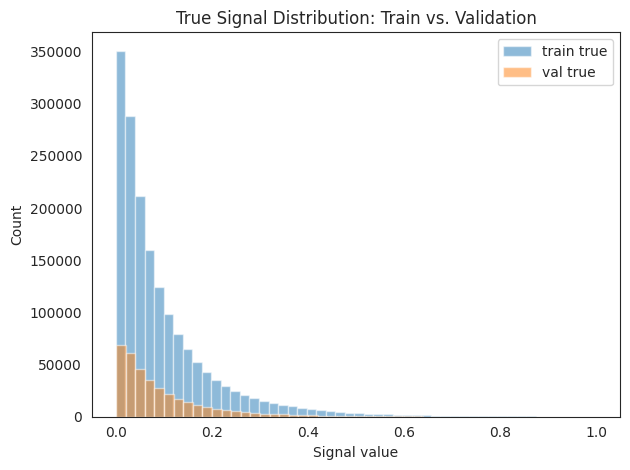

In [8]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

Training sees 3792 unique trading days per epoch.

Model parameters: total=417,283, trainable=417,283

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 3, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 128, 'TRANSFORMER_LAYERS': 2, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.1, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.1, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'attn', 'PRED_HIDDEN': 128, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 70, 'EARLY_STOP_PATIENCE': 7, 'WEIGHT_DECAY': 3e-05, 'CLIPNORM': 3, 'ONECYCLE_MAX_LR': 0.001, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_PR

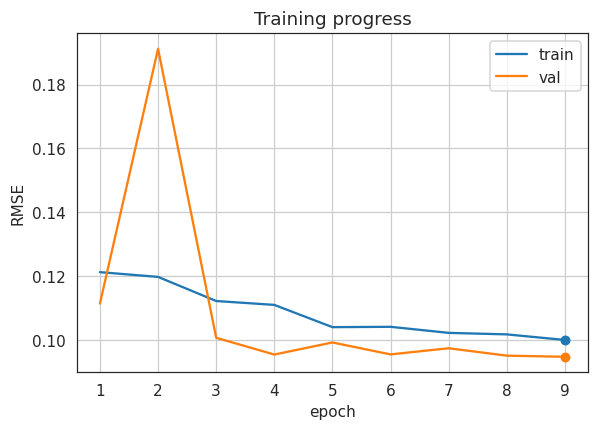

Epoch 1 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

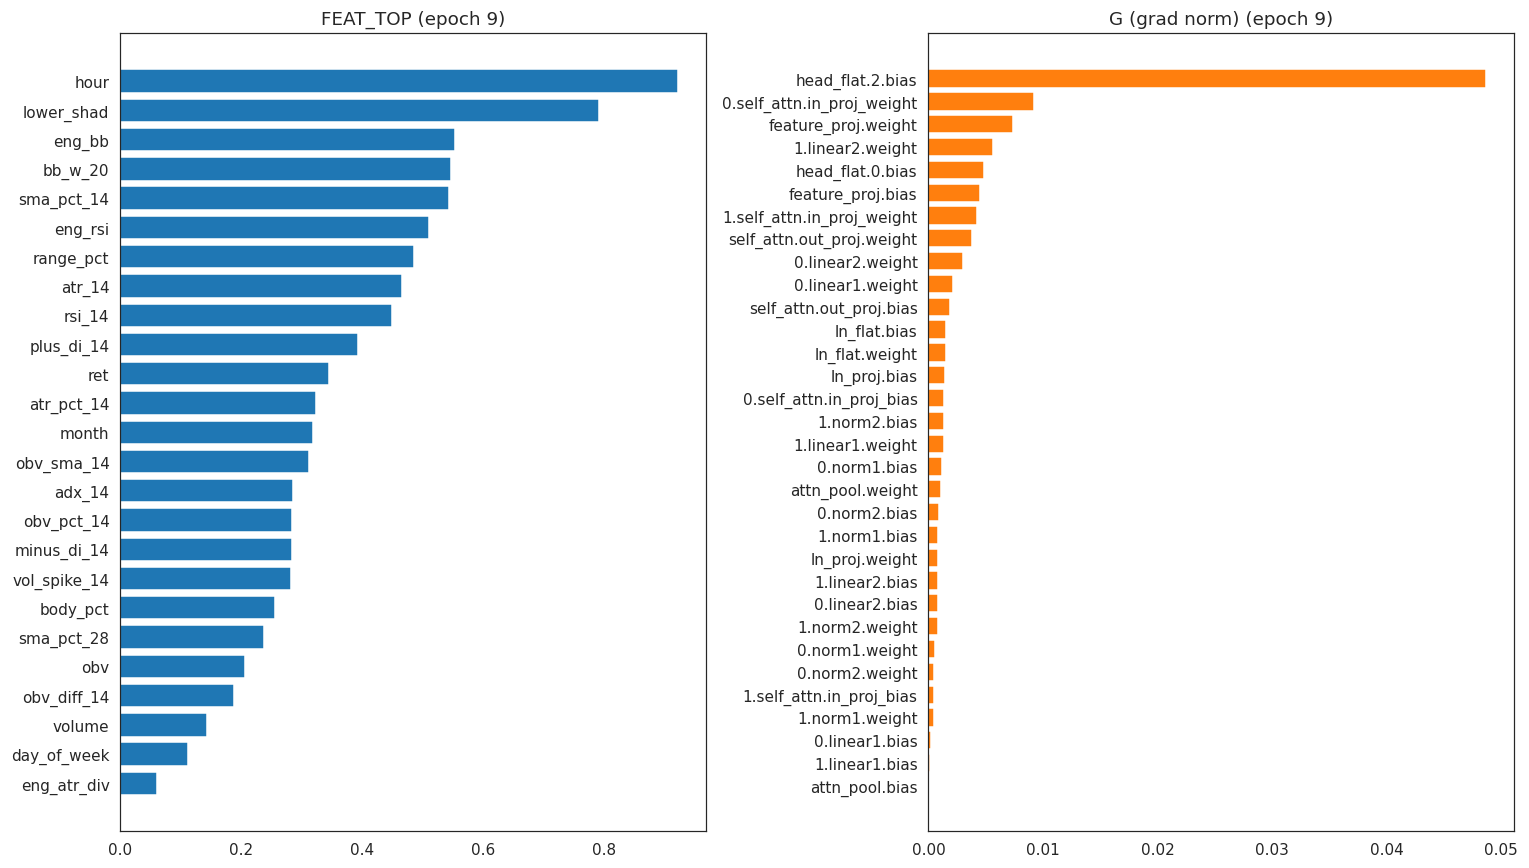

Epoch 01  TRAIN→ RMSE=0.12130, R²=-0.136 |  VALID→ RMSE=0.11147, R²=-0.053 |  lr=1.45e-04 |  loss=1.47131e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.11981, R²=-0.109 |  VALID→ RMSE=0.19119, R²=-2.098 |  lr=2.70e-04 |  loss=1.43546e-02 |  improved=False


Epoch 3 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.11226, R²=0.027 |  VALID→ RMSE=0.10076, R²=0.139 |  lr=4.50e-04 |  loss=1.26032e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.11105, R²=0.048 |  VALID→ RMSE=0.09551, R²=0.227 |  lr=6.51e-04 |  loss=1.23321e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.10408, R²=0.163 |  VALID→ RMSE=0.09929, R²=0.164 |  lr=8.31e-04 |  loss=1.08336e-02 |  improved=False


Epoch 6 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.10419, R²=0.162 |  VALID→ RMSE=0.09556, R²=0.226 |  lr=9.56e-04 |  loss=1.08558e-02 |  improved=False


Epoch 7 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.10229, R²=0.192 |  VALID→ RMSE=0.09748, R²=0.195 |  lr=1.00e-03 |  loss=1.04641e-02 |  improved=False


Epoch 8 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.10182, R²=0.199 |  VALID→ RMSE=0.09517, R²=0.232 |  lr=9.99e-04 |  loss=1.03675e-02 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.10007, R²=0.227 |  VALID→ RMSE=0.09481, R²=0.238 |  lr=9.98e-04 |  loss=1.00136e-02 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

In [ ]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader
)